<div class="alert alert-block alert-info"><h1 style="text-align:center;color:black"> 📷 MNIST Fashion 🚀 </h1> </div>


![download.png](https://i.imgur.com/HIw76CA.jpg)

<h5 style='text-align:center'>Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples.</h5>

Each example is a 28x28 grayscale image, associated with a label from 10 classes. The dataset serves as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Any one who started their Deep learning Journey will mostly start with MNIST or CIFAR 10 as their initial problem set. MNSIT might be very easy for most of the beginers since it is a very small dataset and easy to get good accuracy, with bit of optimizations you can easily acheieve top 10% result.

**If you find this Kernal helpful , Please Upvote the notebook.**

<div class="alert alert-block alert-warning"><h2 style="text-align:Center;color:black">Table of Content </h2> </div>

1. [Introduction 💥](#1)
1. [Data Description](#2)
1. [Loading Libraries📖](#3)
1. [Get the data📁](#4)
1. [Data Exploration📊](#5)
1. [Data Preparation 🛠️](#6)
    1. [Train Test Split](#7)
1. [Deep learning Model ⚙️](#8)
    1. [Baseline Model (VGG 3 Blocks)](#9)
    1. [Improving Model](#10)
1. [Prediction](#11)
1. [Visualize Classified Images](#12)
    1. [Correctly Classified Images](#13)
    1. [Incorrectly Classified Images](#14)
1. [Conclusion](#15)

<a id='1'></a>
<div class="alert alert-block alert-danger"><h2 style="text-align:center;color:black"> Introduction 💥</h2> </div>


In this work, I will train a Convolutional Neural Network classifier with VGG style 3 block of convolution layers using the Keras deep learning library. The model is first trained for 50 epochs with batch size of 64, compiled with categorical_crossentropy loss function and Adam optimizer. I added data augmentation, which generates new training samples by rotating, shifting and zooming on the training samples.

I will first split the original training data (60,000 images) into 80% training (48,000 images) and 20% validation (12000 images) optimize the classifier, while keeping the test data (10,000 images) to finally evaluate the accuracy of the model on the data it has never seen. This helps to see whether I'm over-fitting on the training data and whether I should lower the learning rate and train for more epochs if validation accuracy is higher than training accuracy or stop over-training if training accuracy shift higher than the validation.

<a id='2'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Description </h2> </div>

Each training and test example is assigned to one of the following labels:

* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
*  7 Sneaker
* 8 Bag
* 9 Ankle boot


<a id='3'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Loading Libraries </h2> </div>

In [1]:
# basic
import numpy as np
import pandas as pd

#visulas
import matplotlib.pyplot as plt
import seaborn as sns

#Scikit-learn
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from keras.layers import Dense,MaxPool2D,Conv2D,BatchNormalization,Flatten,Dropout

<a id='4'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Get the data </h2> </div>
We are going to import data directly from the Keras datasets instead of getting it from kaggle data, since keras already has the cleaned version of the same data so lets use it.

In [2]:
# load data
(train,train_label),(test,test_label) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
print('The shape of train',train.shape)

print('The shape of train_label',train_label.shape)

print('The shape of test',test.shape)

print('The shape of test_label',test_label.shape)

The shape of train (60000, 28, 28)
The shape of train_label (60000,)
The shape of test (10000, 28, 28)
The shape of test_label (10000,)


<a id='5'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Exploration </h2> </div>

First, we start by visualizing the variable of interest.

Let's view more images in a grid format.

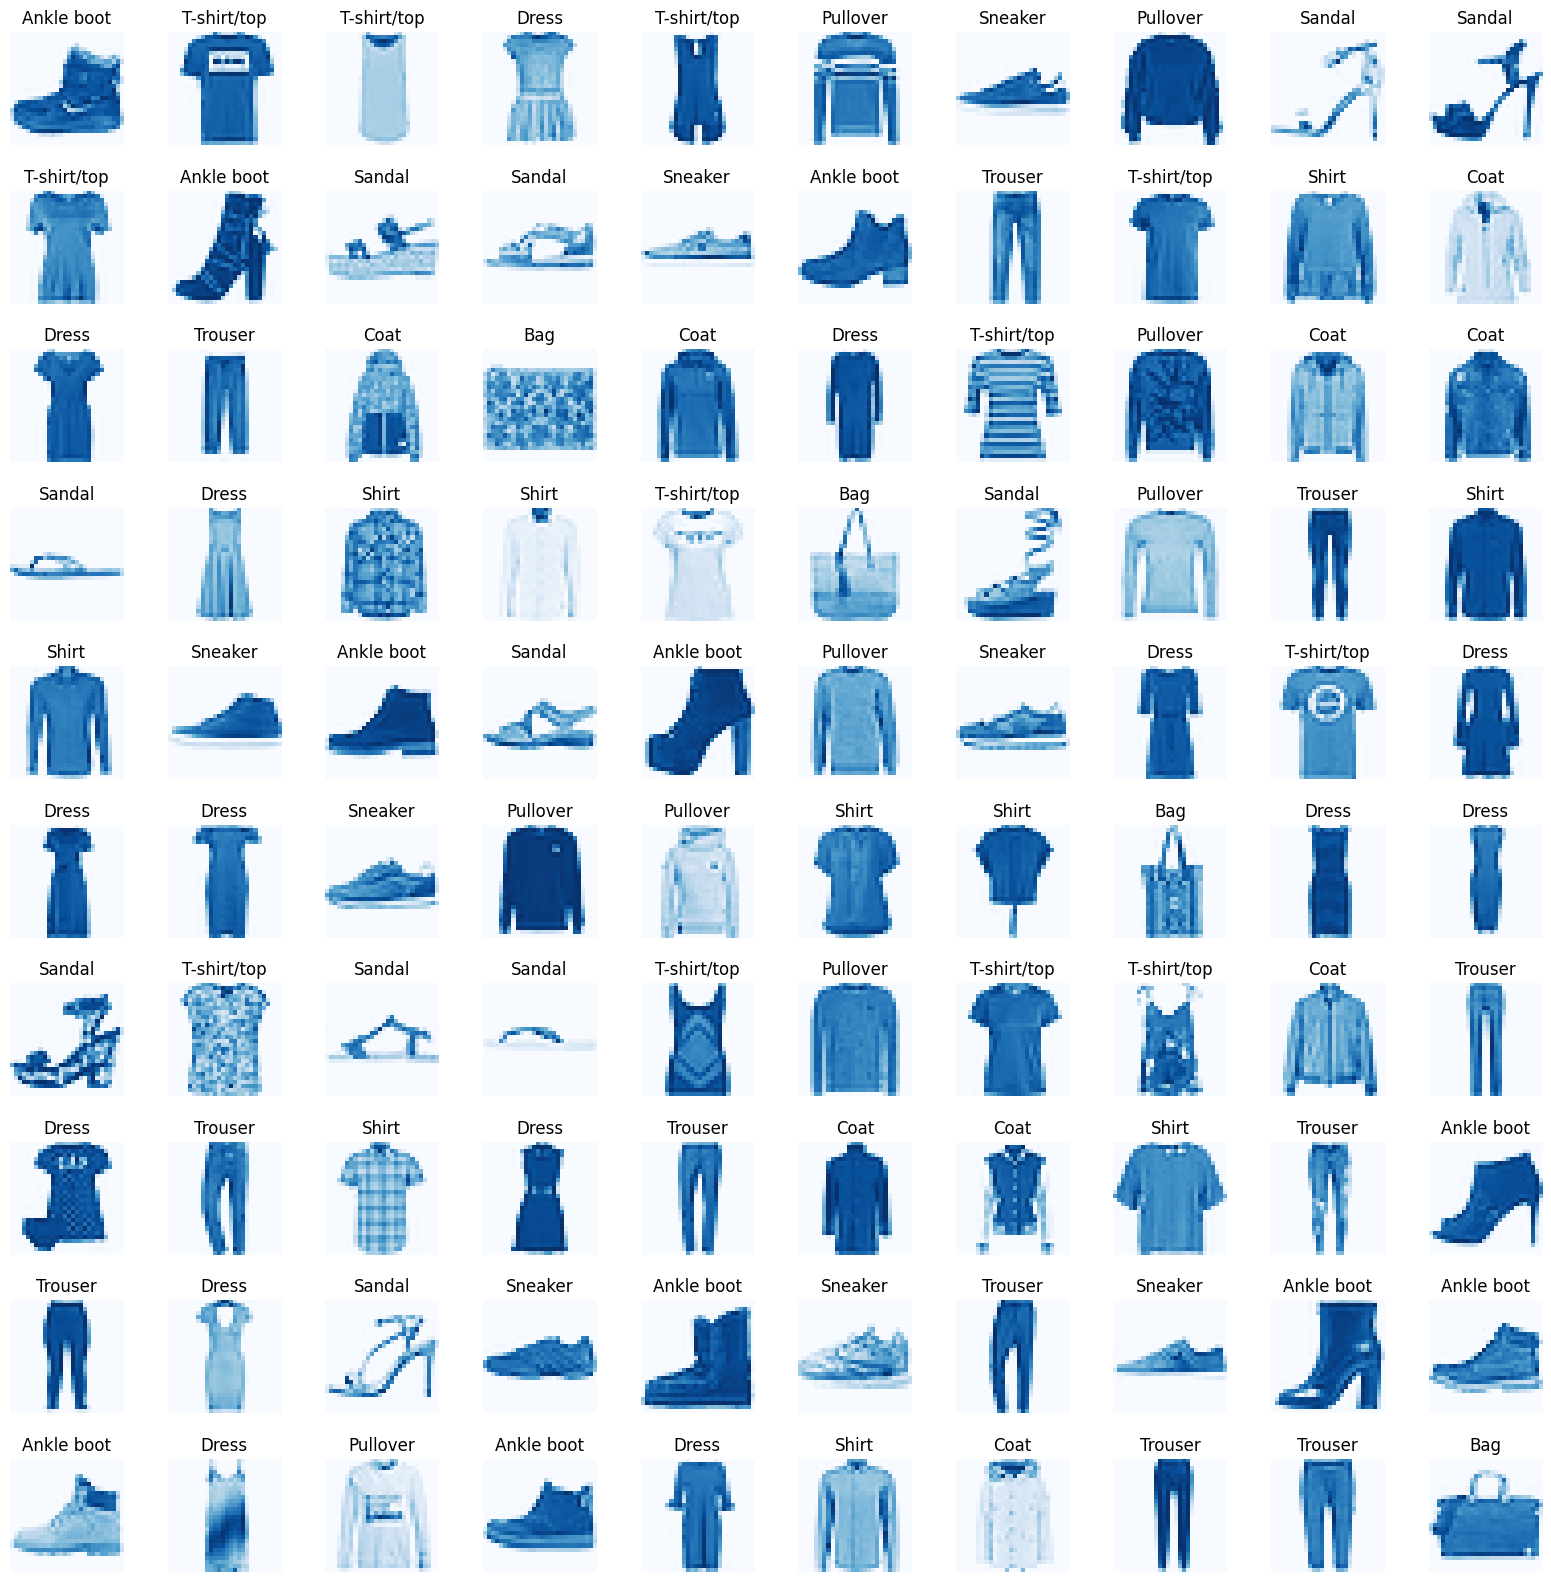

In [4]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)

labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in range(100):

    plt.subplot(10,10,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(train[i],cmap='Blues')
    plt.title(labels[int(train_label[i])],fontsize=12)
    plt.axis('off')

plt.show()

Now we will Create a barplot to see the class distrubtion in trainting and testing set.

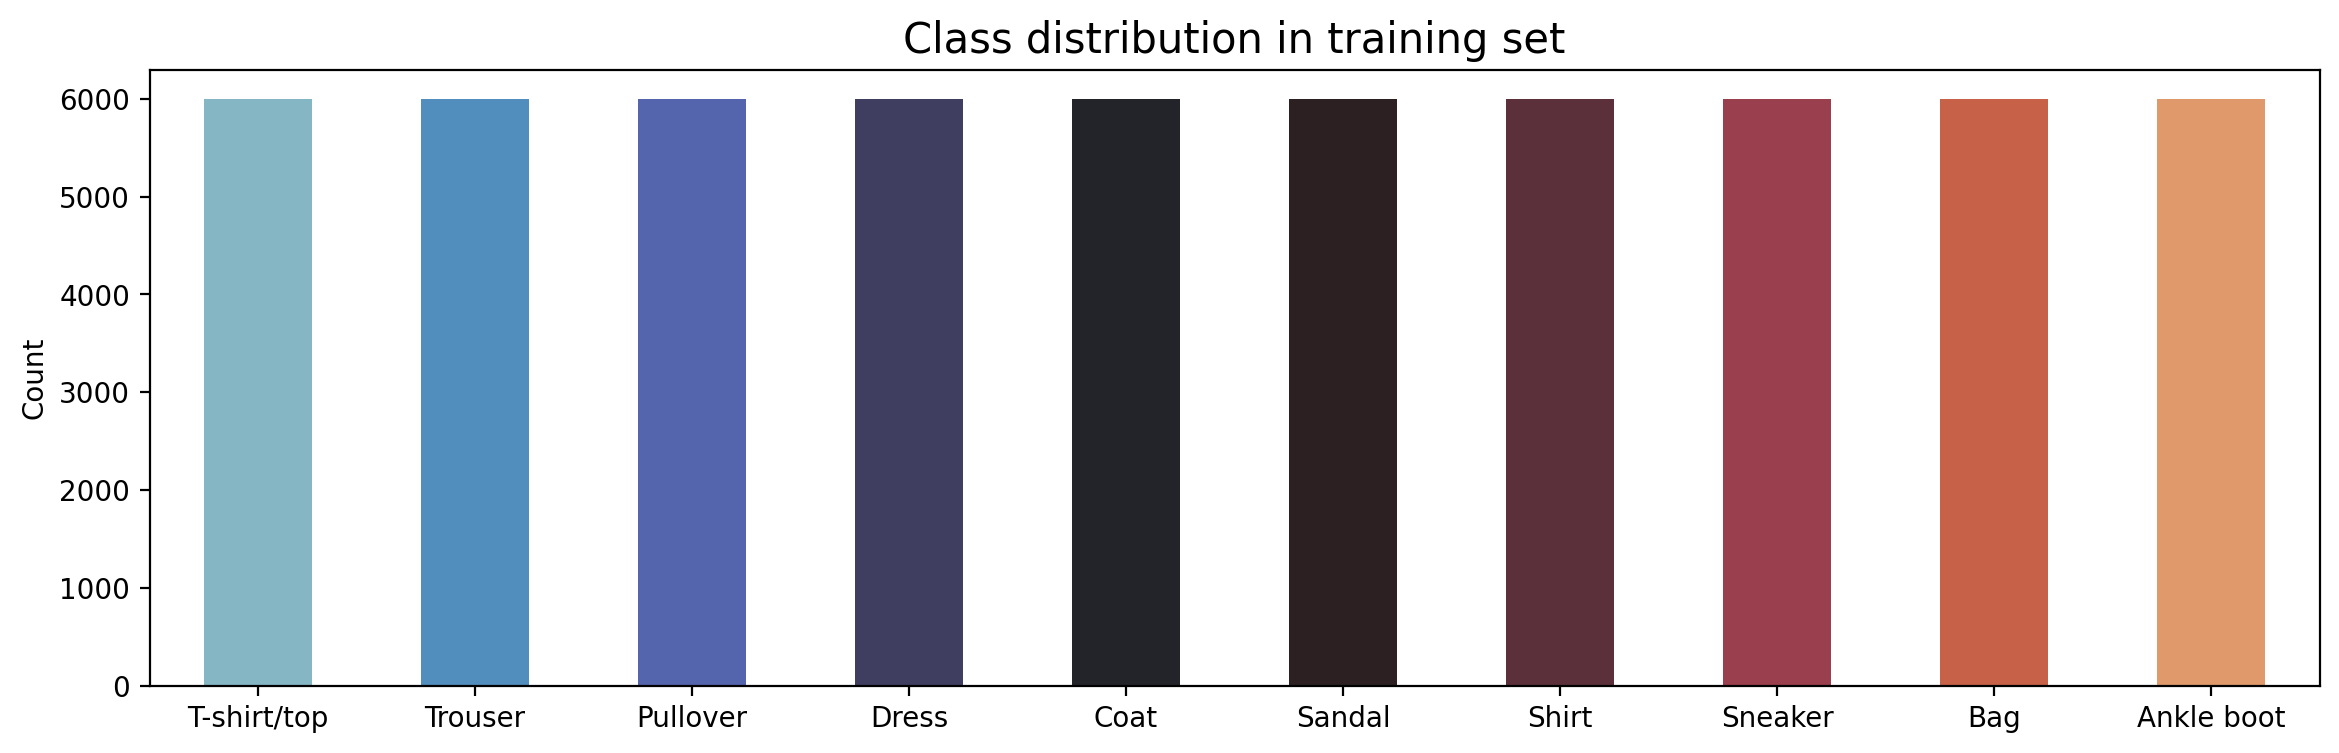

In [5]:
label,count = np.unique(train_label,return_counts=True)
uni = pd.DataFrame(data=count,index=labels,columns=['Count'])

plt.figure(figsize=(14,4),dpi=200)
sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.5).set_title('Class distribution in training set',fontsize=15)
plt.show()

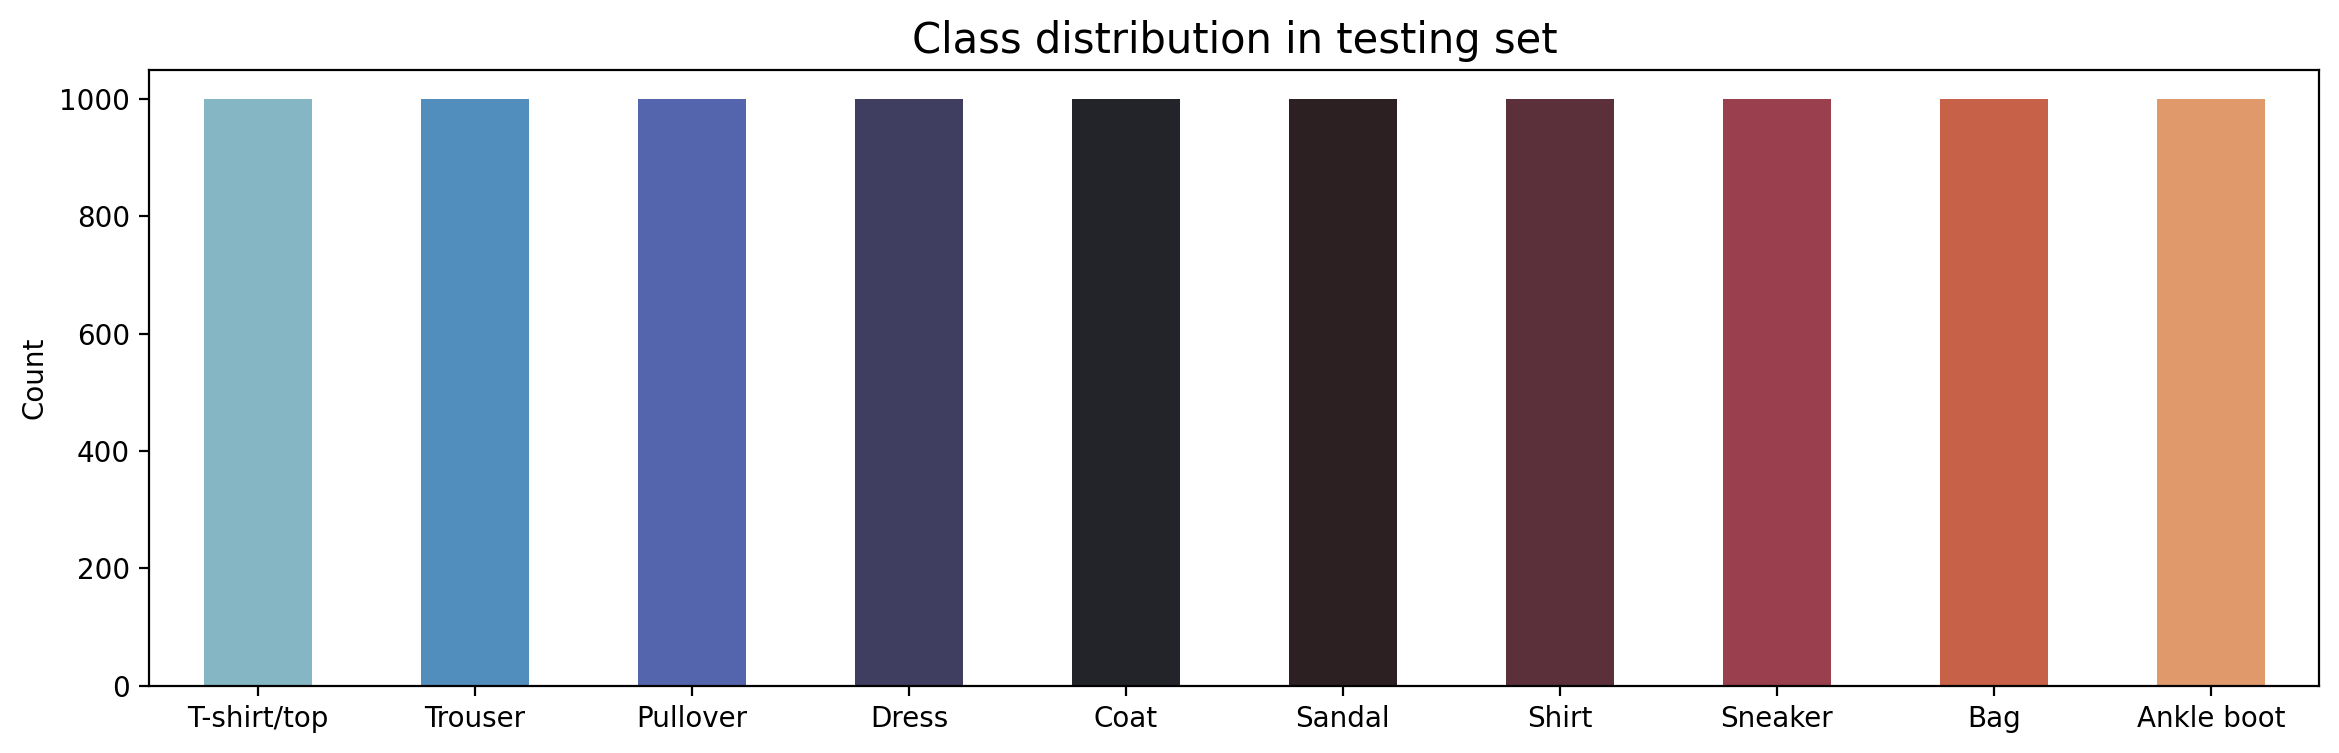

In [6]:
# count for Testing dataset
label,count = np.unique(test_label,return_counts=True)
uni = pd.DataFrame(data=count,index=labels,columns=['Count'])

plt.figure(figsize=(14,4),dpi=200)
sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.5).set_title('Class distribution in testing set',fontsize=15)
plt.show()

<a id='6'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Preparation </h2> </div>

After loading and splitting the data, I preprocess them by reshaping them into the shape the network expects and scaling them so that all values are in the [0, 1] interval. Previously, for instance, the training data were stored in an array of shape (60000, 28, 28) of type uint8 with values in the [0, 255] interval. I transform it into a float32 array of shape (60000, 28 * 28) with values between 0 and 1.

In [7]:
# function to change the data type and normalize the data
# scaling the images
def pre_process(data):
    return data/255

# function to chnage the labels into categorical data
def to_cat(data):
    return to_categorical(data,num_classes=10)

In [8]:
train = pre_process(train)
test = pre_process(test)

print('The shape of train_label before one hot encoding',train_label.shape)

train_label = to_cat(train_label)

print('The shape of y_train after one hot encoding',train_label.shape)

The shape of train_label before one hot encoding (60000,)
The shape of y_train after one hot encoding (60000, 10)


<a id='7'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Train Test Split </h2> </div>

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train, train_label, test_size=0.2, random_state=42)

print('The number of train data is ',X_train.shape[0])
print('The number of test data is ',X_test.shape[0])

The number of train data is  48000
The number of test data is  12000


In [10]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

<a id='8'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Deep Learning Model </h2> </div>

This CNN takes as input tensors of shape (image_height, image_width, image_channels). In this case, I configure the CNN to process inputs of size (28, 28, 1), which is the format of the FashionMNIST images. I do this by passing the argument input_shape=(28, 28, 1) to the first layer.

In [11]:
# 3 block vgg style model
# Base of the model

model = models.Sequential()

# block 1
model.add(Conv2D(32,3,activation='relu',padding='same',input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(32,3,activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.2))

# block 2
model.add(Conv2D(64,3,activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,3,activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.3))

#block 3
model.add(Conv2D(128,3,activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,3,activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
#model.add(MaxPool2D())

# output layers
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(10,activation='softmax'))


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                        

In [13]:
# model compile
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# early_stoping callback
early_stoping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

<a id='9'></a>
<div class="alert alert-block alert-danger"><h4 style="text-align:center;color:black"> Base Model </h4> </div>

In [14]:
fashion = model.fit(X_train,y_train,
                    validation_data=(X_test,y_test),
                    epochs=10,
                    callbacks=[early_stoping],
                    verbose=0)

loss3,acc3 = model.evaluate(X_test,y_test,batch_size = 64, verbose = 0)

In [15]:
print('The accuracy of the Base Model is:',acc3*100)
print('The Loss of the Base Model is:',loss3)

The accuracy of the Base Model is: 92.72500276565552
The Loss of the Base Model is: 0.2050366848707199


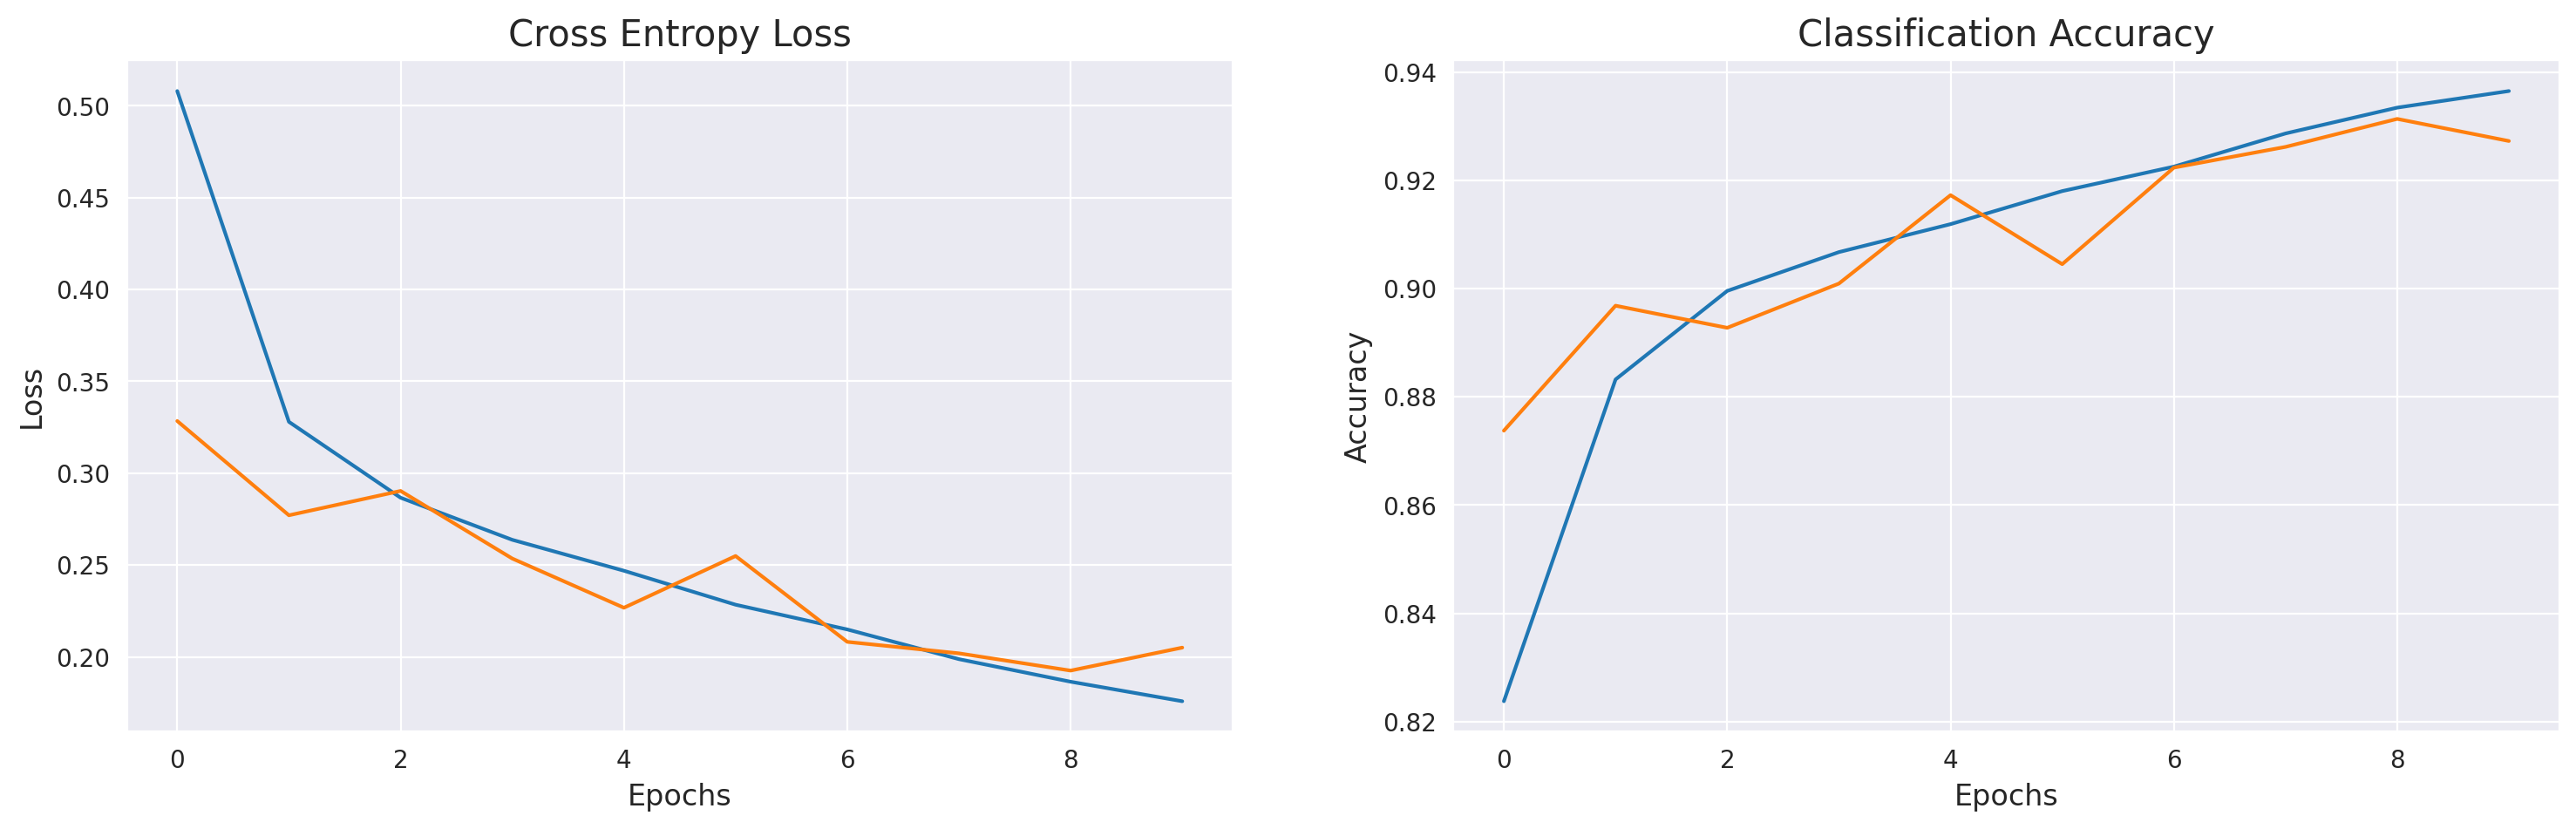

In [16]:
# plots for accuracy and Loss with epochs

error = pd.DataFrame(fashion.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

<a id='10'></a>
<div class="alert alert-block alert-danger"><h4 style="text-align:center;color:black"> Improving Model </h4> </div>

In [18]:
# Image Augmentation
datagen = ImageDataGenerator(#rotation_range=50,
                             horizontal_flip=True,
                             width_shift_range=0.1,
                             height_shift_range=0.1
                            )


train_gen = datagen.flow(X_train,y_train, batch_size=64)

fashion = model.fit(train_gen,
                    validation_data=(X_test,y_test),
                    epochs=5,
                   callbacks=[early_stoping])

Epoch 1/5
750/750 [==============================] - 27s 35ms/step - loss: 0.2200 - accuracy: 0.9205 - val_loss: 0.1906 - val_accuracy: 0.9323
Epoch 2/5
750/750 [==============================] - 20s 26ms/step - loss: 0.2154 - accuracy: 0.9216 - val_loss: 0.1796 - val_accuracy: 0.9348
Epoch 3/5
750/750 [==============================] - 20s 26ms/step - loss: 0.2136 - accuracy: 0.9232 - val_loss: 0.1875 - val_accuracy: 0.9345
Epoch 4/5
750/750 [==============================] - 21s 28ms/step - loss: 0.2111 - accuracy: 0.9240 - val_loss: 0.1804 - val_accuracy: 0.9364
Epoch 5/5
750/750 [==============================] - 20s 27ms/step - loss: 0.2095 - accuracy: 0.9238 - val_loss: 0.1954 - val_accuracy: 0.9303


In [19]:
# Evaluvate
loss3,acc3 = model.evaluate(X_test,y_test,batch_size = 64, verbose = 0)

print('The accuracy of the Final Model is:',acc3*100)
print('The Loss of the Final Model is:',loss3)

The accuracy of the Final Model is: 93.03333163261414
The Loss of the Final Model is: 0.19542855024337769


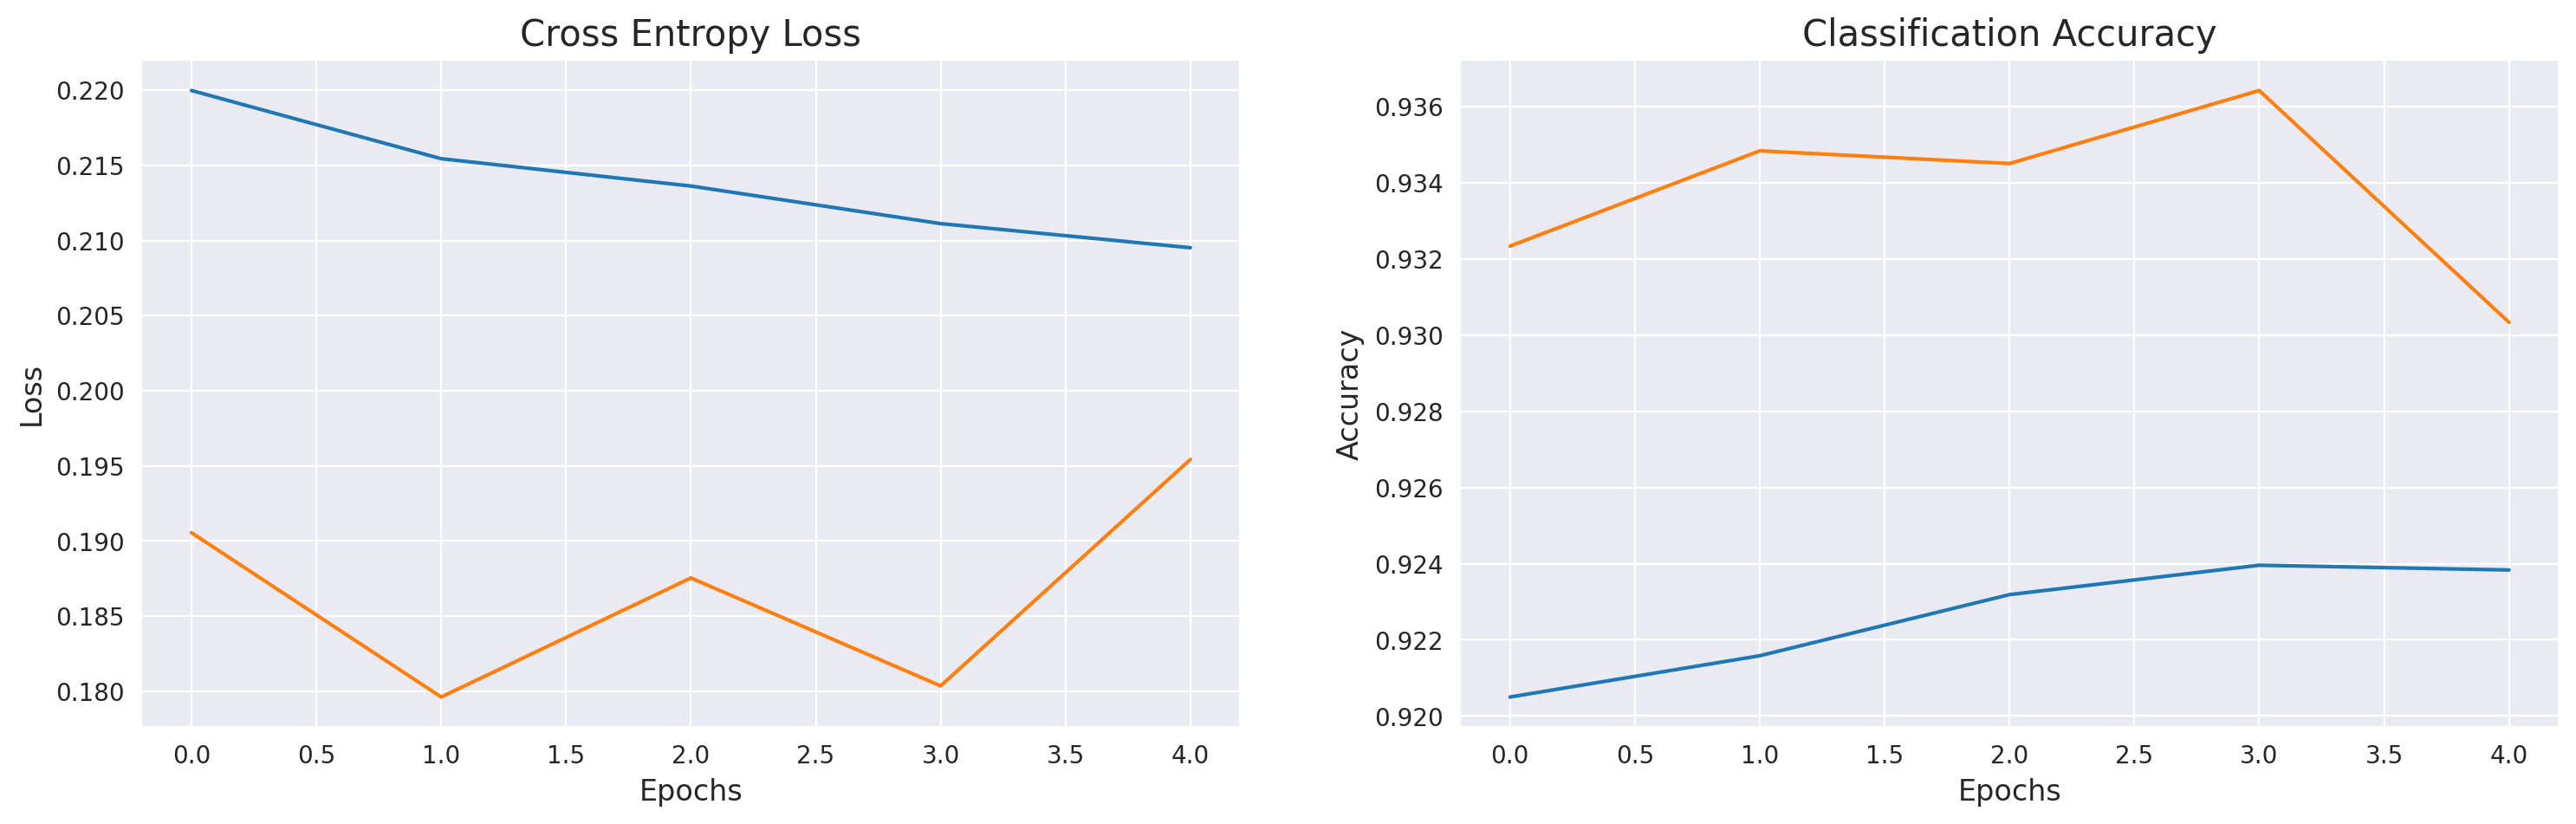

In [20]:
# plots for accuracy and Loss with epochs

error = pd.DataFrame(fashion.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

<a id='11'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Prediction </h2> </div>
We can now load the final model and evaluate it on the hold out test dataset.

In [21]:
y_pred = model.predict(test)
y_pred = np.argmax(y_pred,axis=1)

313/313 [==============================] - 1s 3ms/step


first, we will print the classification report.

In [22]:
print(classification_report(test_label,y_pred,target_names=labels))

              precision    recall  f1-score   support

 T-shirt/top       0.93      0.83      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.94      0.88      0.91      1000
       Dress       0.94      0.91      0.93      1000
        Coat       0.84      0.94      0.88      1000
      Sandal       0.98      0.99      0.98      1000
       Shirt       0.77      0.83      0.80      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.99      0.94      0.96      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



* The best accuracy is obtained for Class 1, Class 5, Class 8, Class 9 and Class 7. Worst accuracy is for Class 6.

* The recall is highest for Class 8, Class 5 and smallest for Class 6 and Class 4.

* f1-score is highest for Class 1, Class 5 and Class 8 and smallest for Class 6 followed by Class 4 and Class 2.

Let's view the confusion matrix.

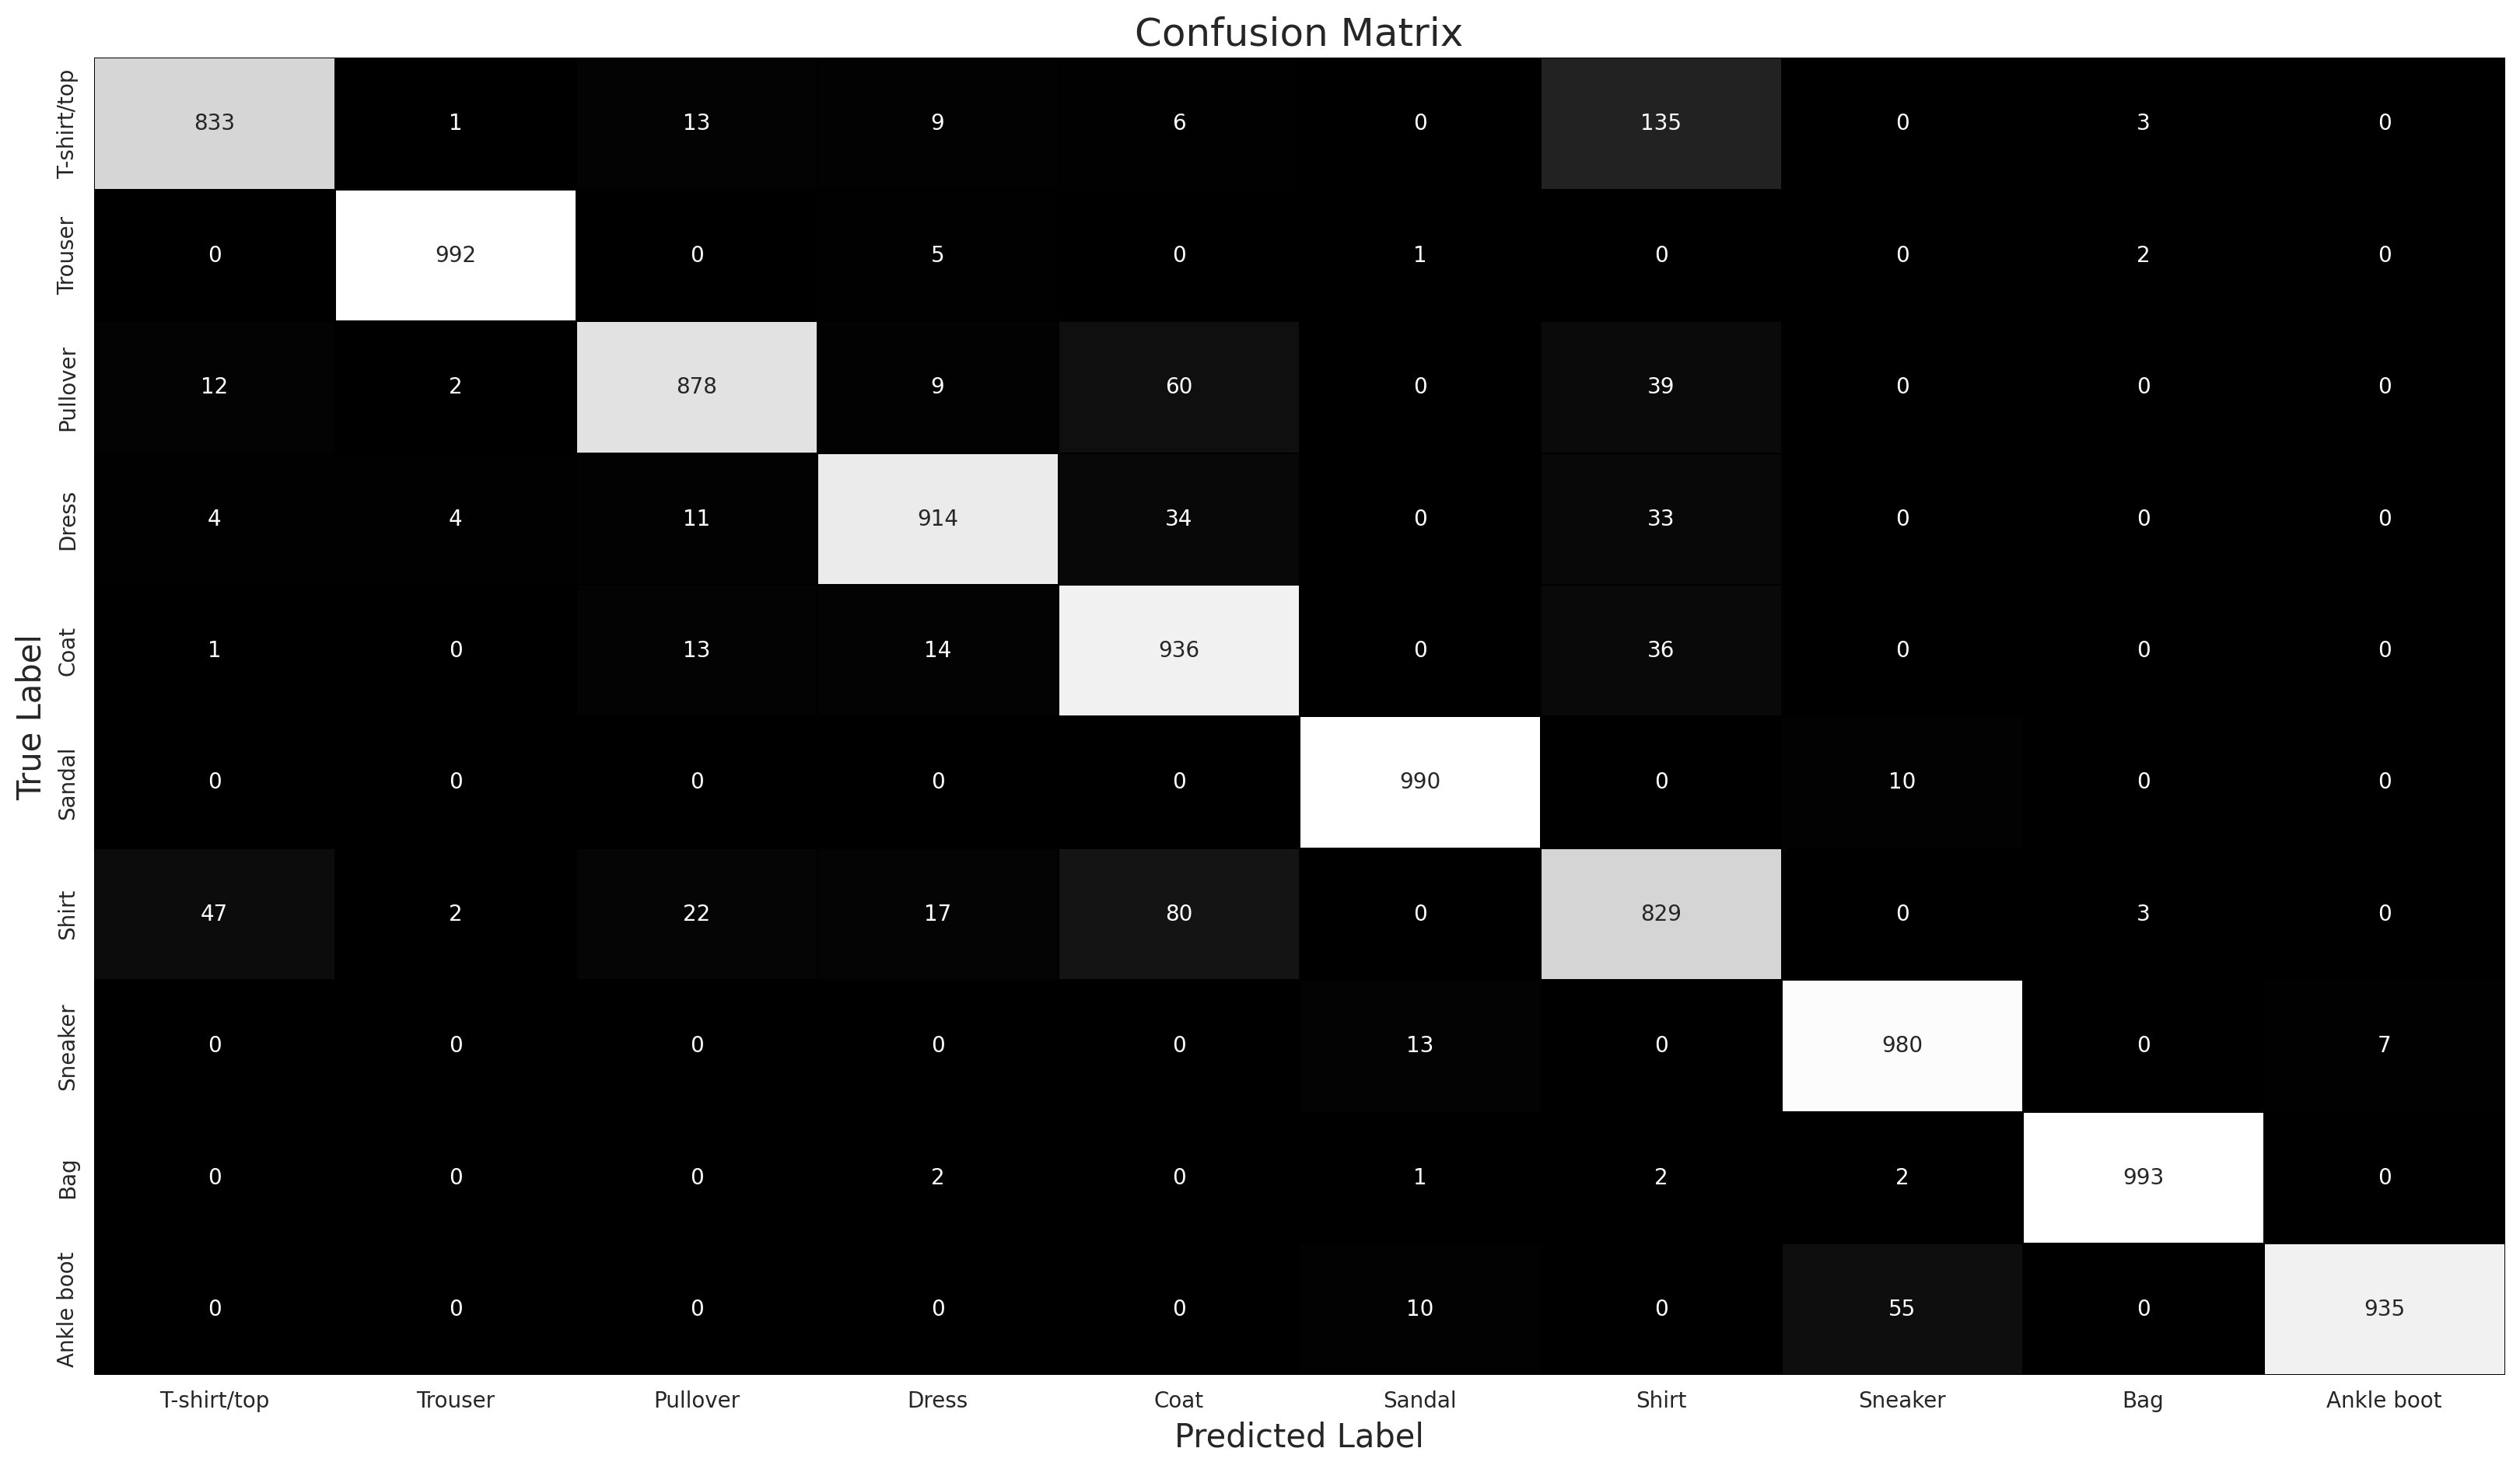

In [23]:
confusion_mtx = confusion_matrix(test_label,y_pred)

f,ax = plt.subplots(figsize = (20,11),dpi=200)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax,cbar=False,xticklabels=labels,yticklabels=labels)
plt.xlabel("Predicted Label",fontsize=15)
plt.ylabel("True Label",fontsize=15)
plt.title("Confusion Matrix",fontsize=18)
plt.show()

<a id='12'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Visualize Classified Images </h2> </div>

In [24]:
p = y_pred[:10000]
y = test_label[:10000]
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 9280
Incorrect predicted classes: 720


In [25]:
# function to plot images
def plot_images(data_index,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(4,4, figsize=(20,10),dpi=200)

    for i, indx in enumerate(data_index[:16]):
        ax[i//4, i%4].imshow(test[indx].reshape(28,28), cmap=cmap)
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title("True:{}  Pred:{}".format(labels[test_label[indx]],labels[y_pred[indx]]))
    plt.show()
    plt.tight_layout()

<a id='13'></a>
<div class="alert alert-block alert-danger"><h4 style="text-align:center;color:black"> Correctly classified images </h4> </div>

<h5 style="text-align:center;color:Green">We visualize few images correctly classified. </h5>

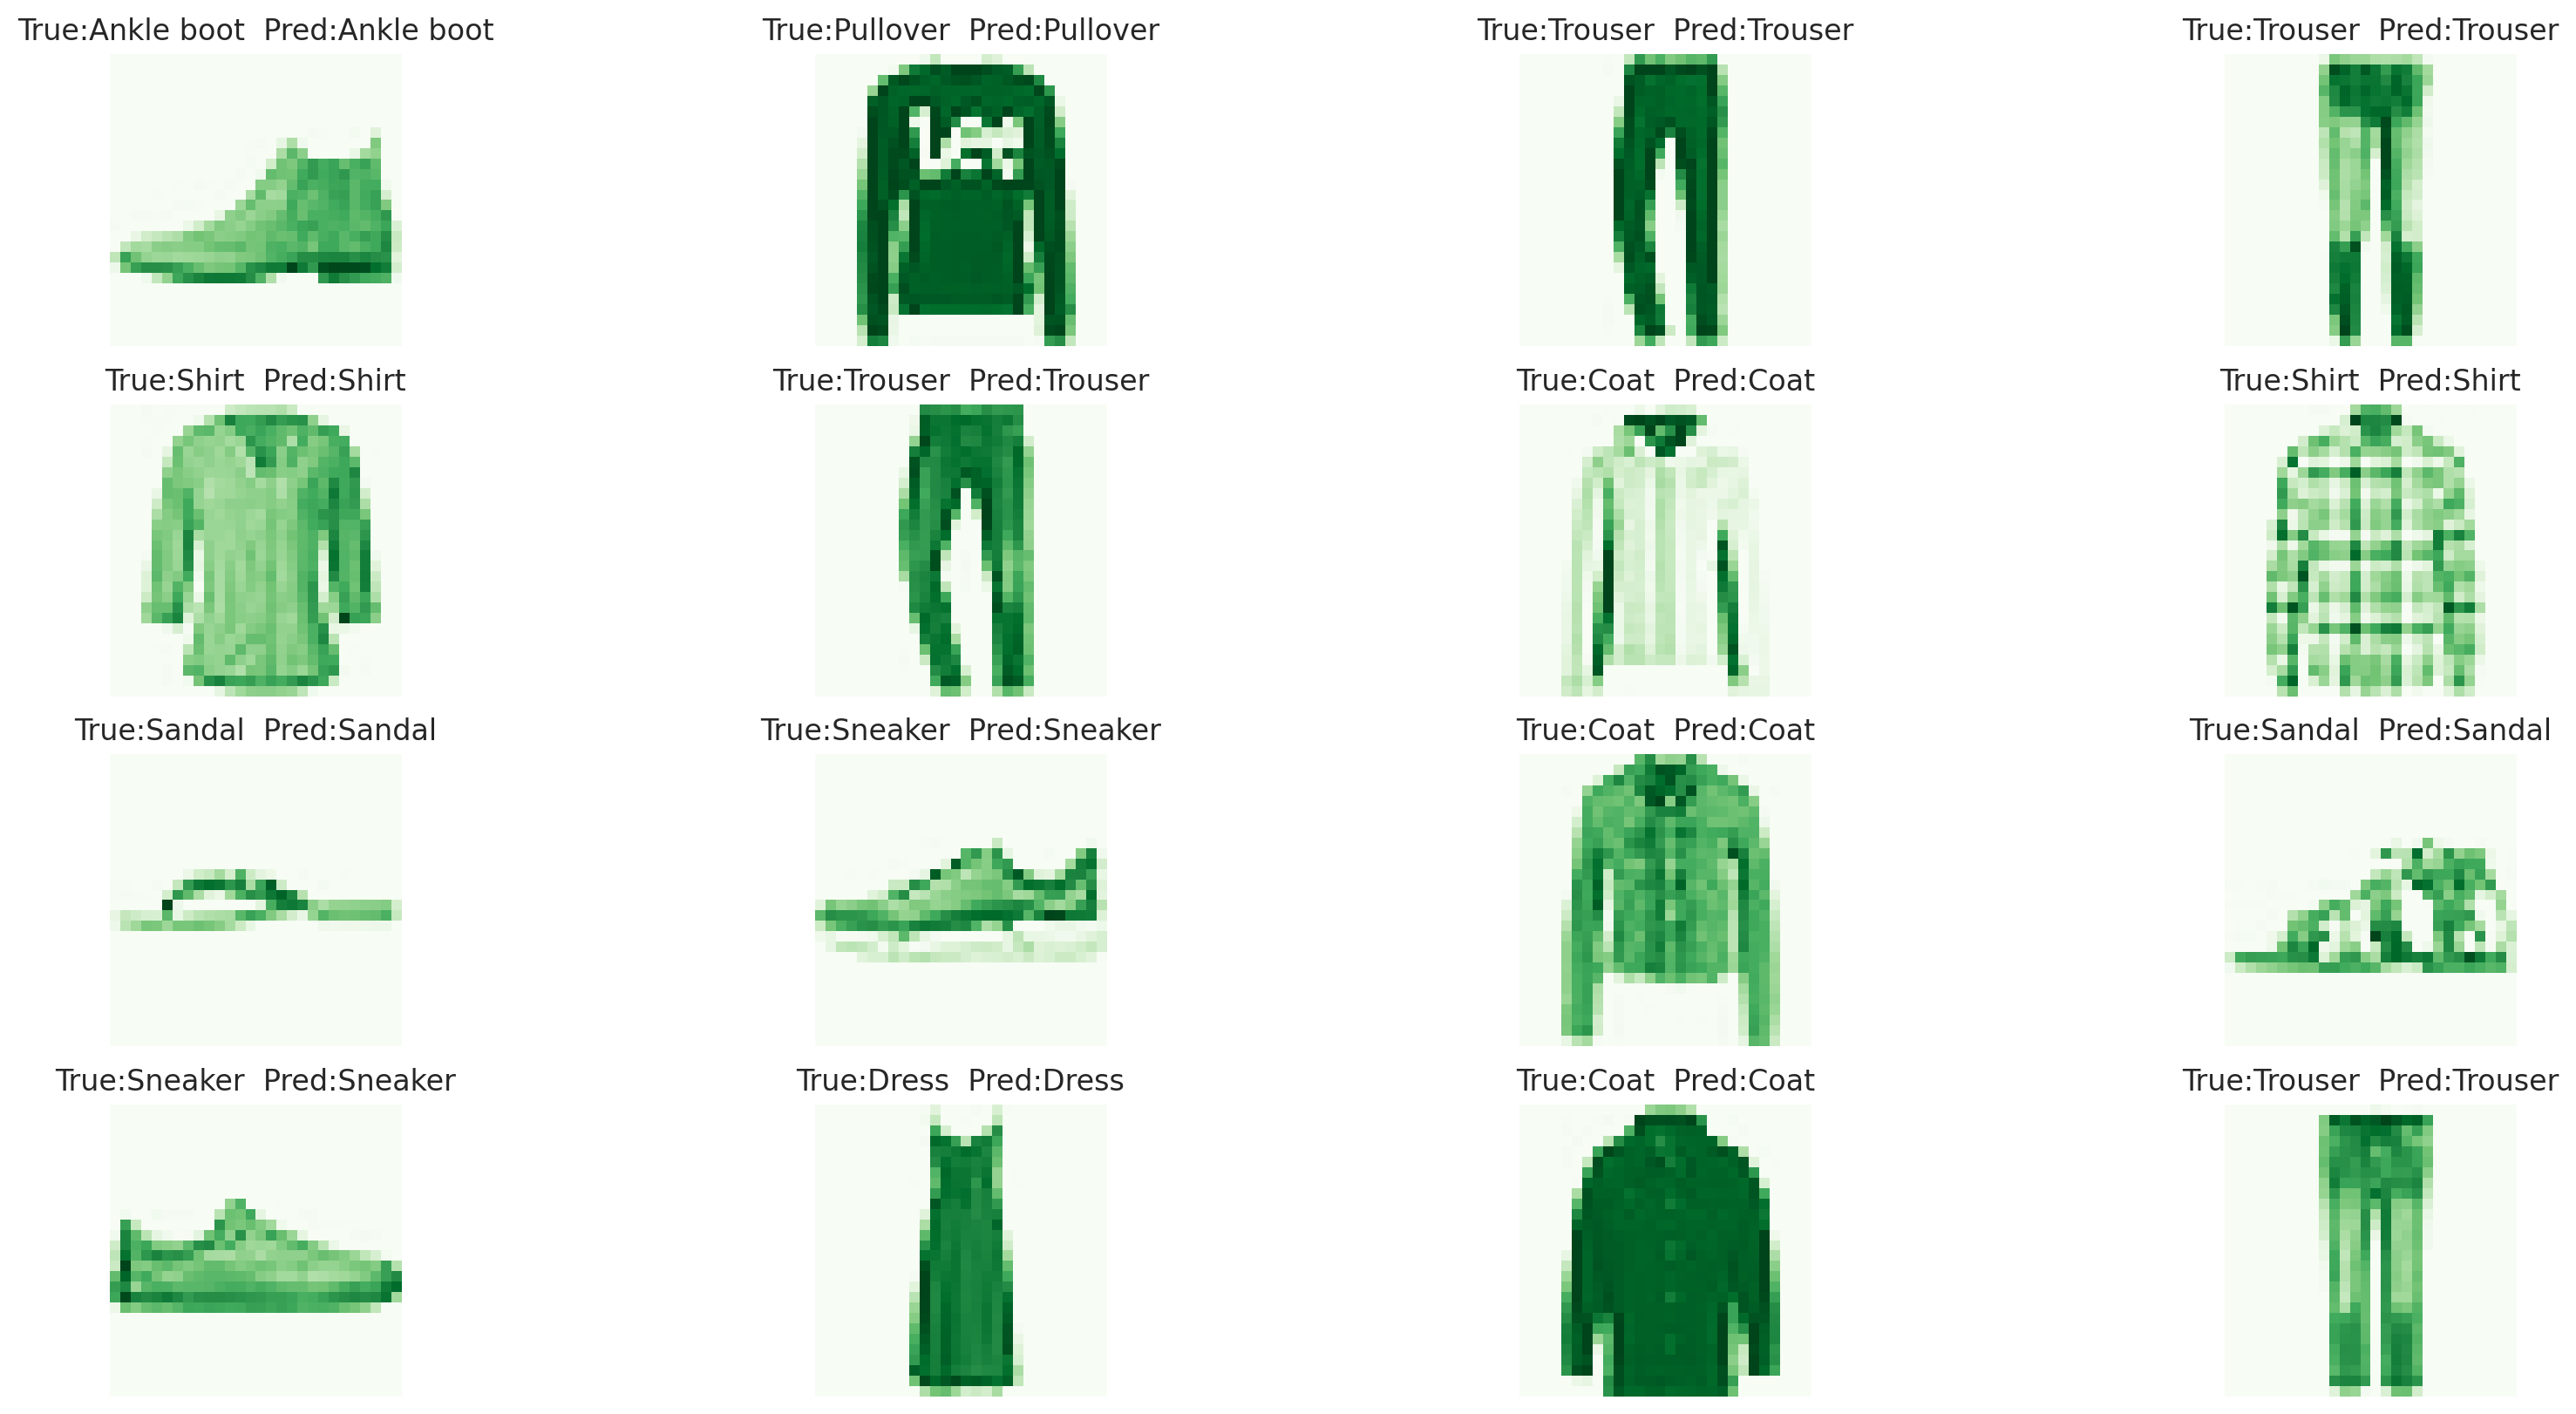

<Figure size 640x480 with 0 Axes>

In [26]:
# correct labeled images
plot_images(correct, "Greens")

<a id='14'></a>
<div class="alert alert-block alert-danger"><h4 style="text-align:center;color:black"> Incorrectly classified images </h4> </div>

<h5 style="text-align:center;color:red">We visualize few images incorrectly classified. </h5>

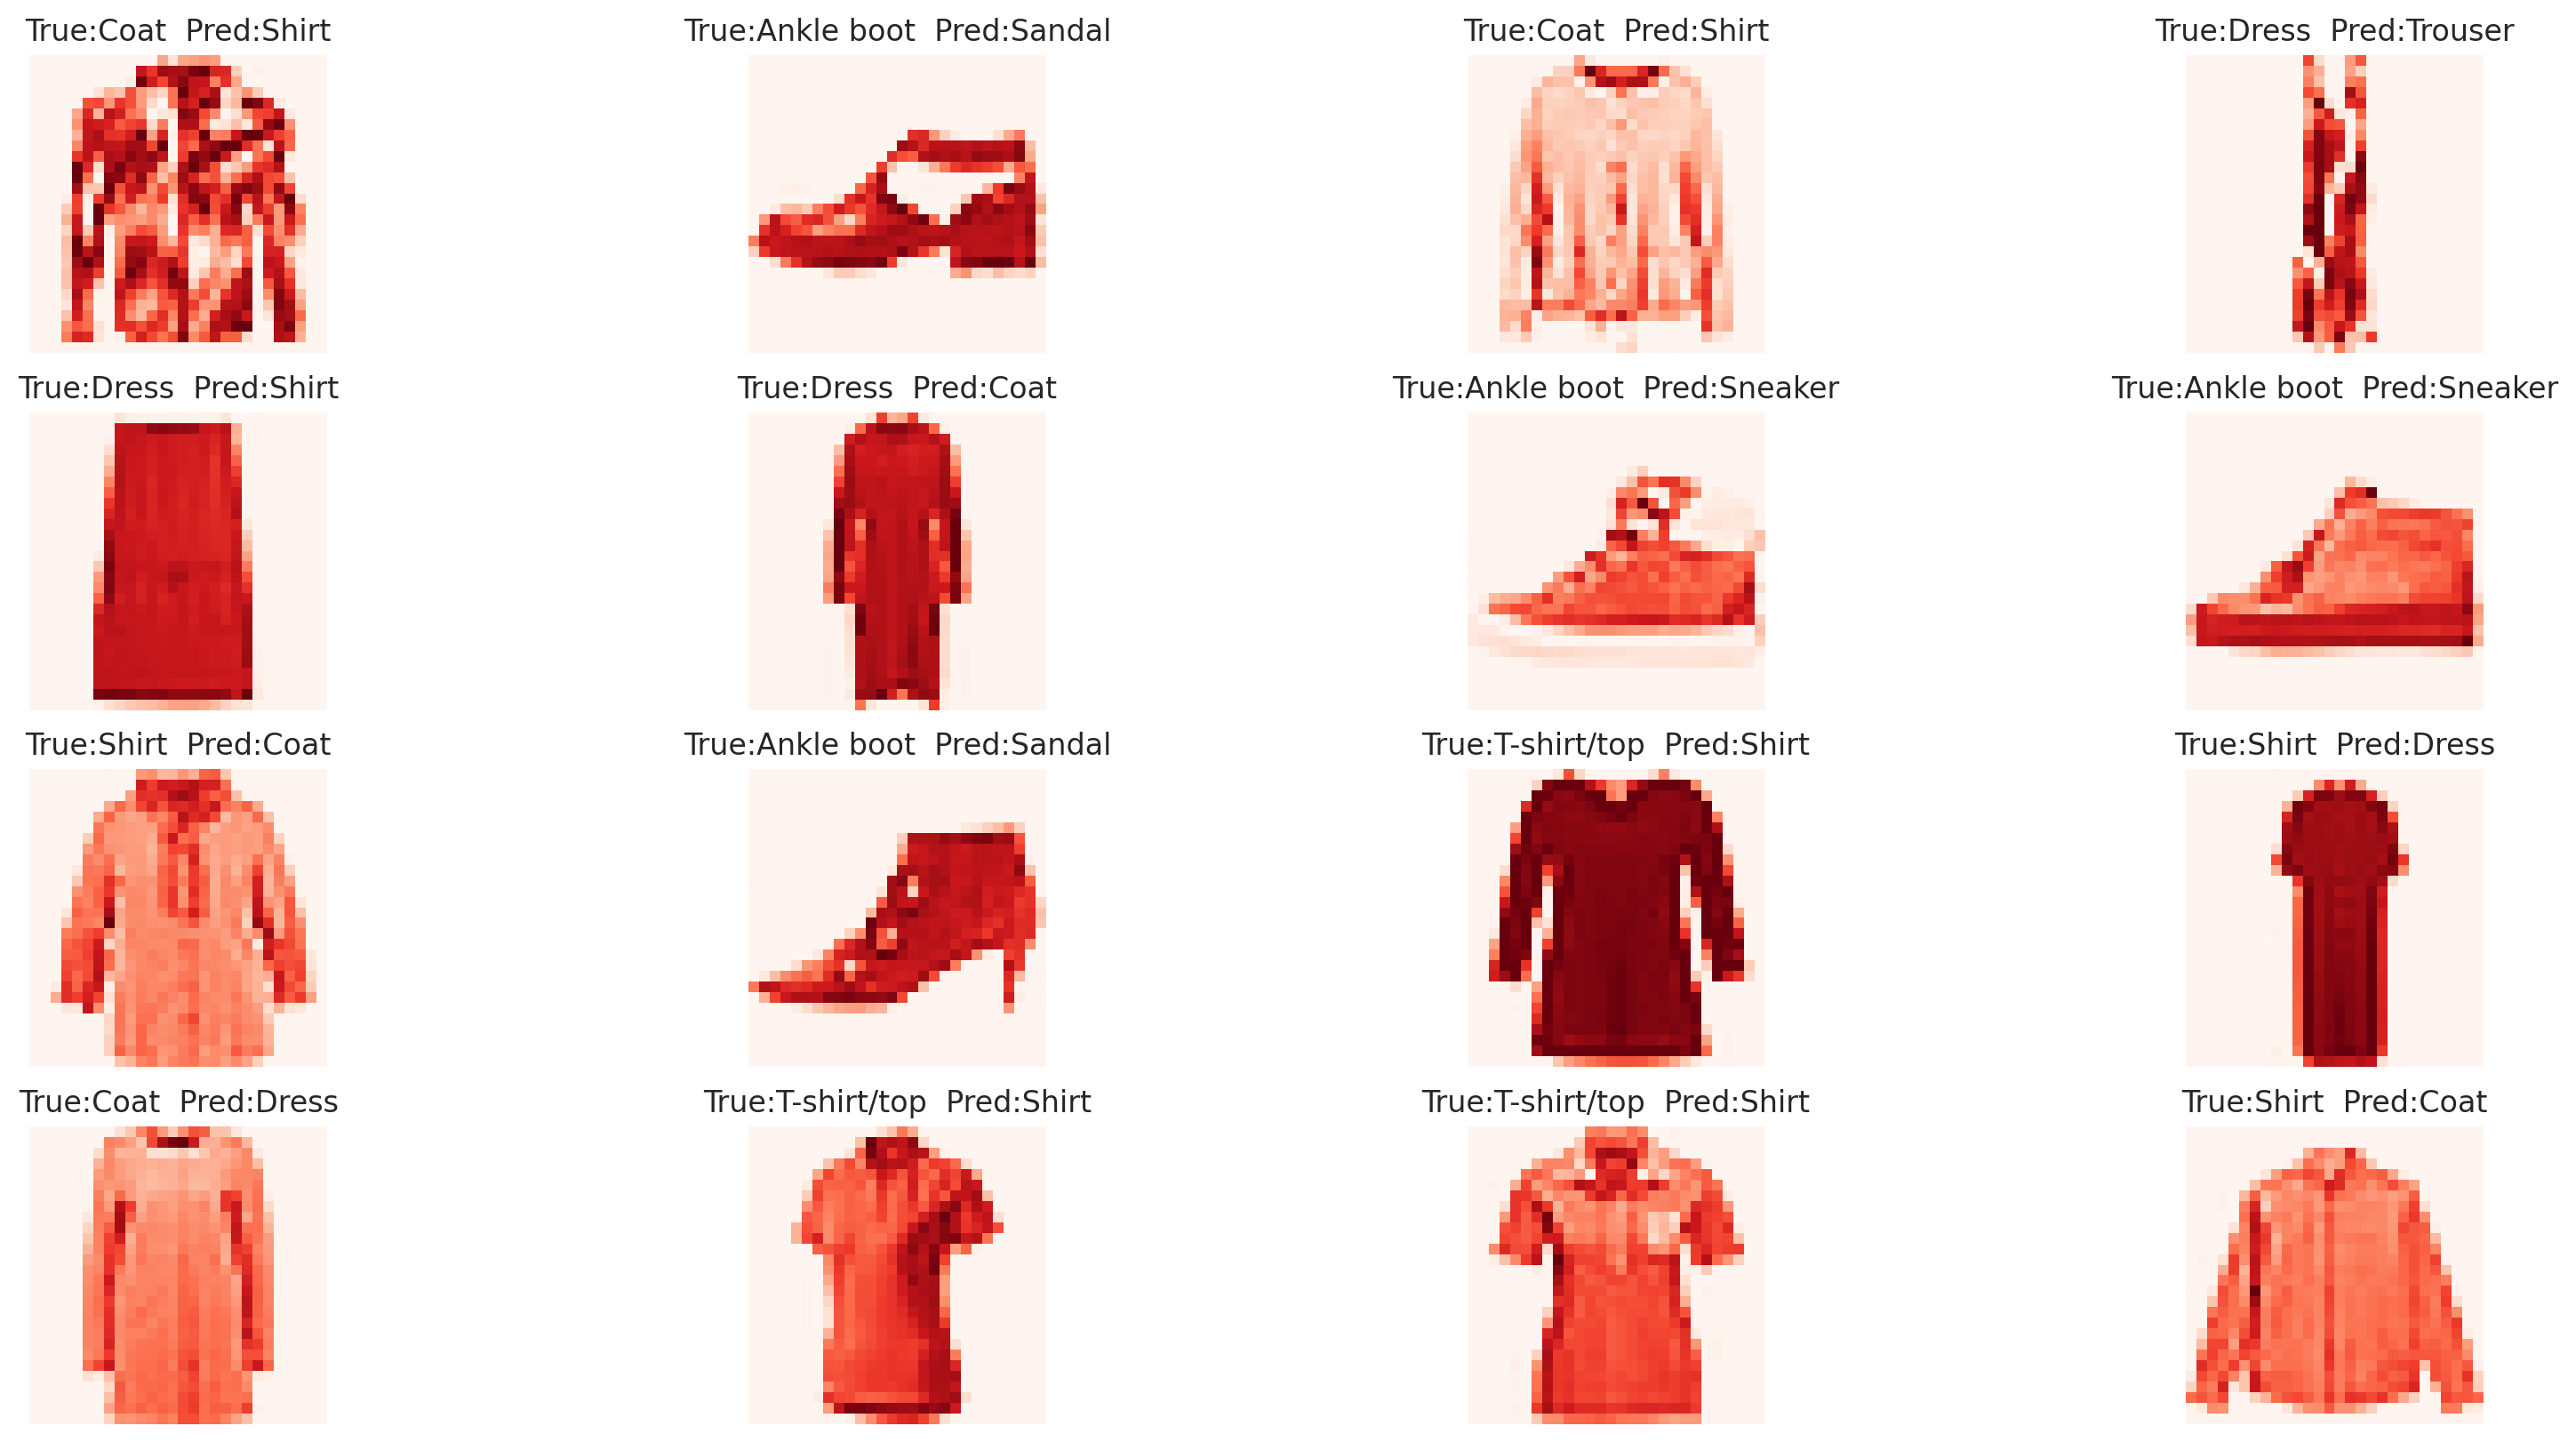

<Figure size 640x480 with 0 Axes>

In [27]:
# incorrect labeled images
plot_images(incorrect, "Reds")

<a id='15'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Conclusion </h2> </div>

* With a complex sequential model with multiple convolution layers and 0 epochs for the training, we obtained an accuracy ~0.92 for test prediction.

* We retrained the model with Image augementaion to the model to increase accuracy.

* We confirmed the model improvement and with the 50 epochs for the training we obtained with the new model an accuracy of ~0.93 for test prediction.

* Only few classes are not correctly classified all the time, especially Class 6 (Shirt) and Class 2 (Pullover).